In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score, make_scorer
from imblearn.over_sampling import SMOTENC

In [2]:
df = pd.read_excel('/home/sam/tirocinio/DB PAROTIDE DEF_corretto.xlsx', sheet_name='Sheet7')
df = df.loc[df['ESCLUDERE'] == 0]
df.reset_index(inplace = True)
df = df.loc[df['COD ISTO'] != 6]
df.reset_index(inplace = True)
df = df[['Segni macro malignità', 'ADC', 'TIC type', 'T2','COD ISTO']]
df['ADC'] = df['ADC'].apply(lambda s: str(s).replace(',', '.')).astype(float)

In [3]:
y = df['COD ISTO'].copy()
X_not_encoded = df[['Segni macro malignità', 'ADC', 'TIC type', 'T2']].copy()
X = pd.get_dummies(X_not_encoded, columns = ['TIC type'])

In [4]:
#devo modificare oppportunamente la funzione del notebook 5
#pongo dei vincoli più stretti ai tuned parameters e 
#modifico la frazione del test set

def esperimento_estrazionefeature(X, y, tuned_parameters = {'criterion':['entropy'],'max_depth': list(range(2,6)),
                'min_samples_leaf': list(range(2,6)),'class_weight':['balanced']}, target_labels = (1,2),
                test_size = 0.25, model_selection = 'gridsearch', scoring_f = accuracy_score,
                cv= 3, random_state_tree = None, n_it = 10, smotenc_aug = False, print_best_tree = False):
    
    scores_ = []
    trees = []
    
    for n in range(n_it):
        
        print('### ITERATION %d ###\n\n' %(n+1))
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, 
                                                            shuffle = True, stratify = y)
        
        print('## Dataset split completed ##')
        
        y_train = [1 if x in target_labels else 0 for x in y_train]
        y_test =  [1 if x in target_labels else 0 for x in y_test]
        
        if smotenc_aug == True:
            
            smt = SMOTENC(k_neighbors = 3, random_state=None, categorical_features=[0,2,3,4,5],
                          sampling_strategy = 'minority')
                
            X_train, y_train = smt.fit_resample(X_train, y_train)
                
            print('## SMOTENC augmentation completed ##')
        
        print('## Labels prepared ##')
        
        print('# Tuning hyper-parameters #\n')
            
        clf = tree.DecisionTreeClassifier(random_state = random_state_tree)
            
        scorer = None

        if scoring_f is f1_score:

            scorer = make_scorer(f1_score, average = 'weighted')
        else:
            scorer = make_scorer(scoring_f)


        if model_selection == 'gridsearch':

            clf = GridSearchCV(clf, tuned_parameters, scoring = scorer, cv = cv, refit = True)
            clf.fit(X_train, y_train)
            params = clf.best_params_
            score_ = clf.best_score_
            clf = clf.best_estimator_
            
        else:

            scores = cross_val_score(clf, X_train, y_train, scoring = scorer, cv = cv )
            clf = clf.fit(X_train, y_train)
            params = clf.get_params()
            score_ = scores.mean()
            
                
        print("Parameters set found:\n")
        print(params)
        print('Feature importances of estimator:\n')
        print(pd.Series(clf.feature_importances_, index = X.columns))
        print()
        print('Scoring function used: ')
        print(scorer)
        print("Cross-validated score of the estimator: %0.3f\n" %( score_))
        print('Scores on test set:')
        print(classification_report(y_test, clf.predict(X_test), zero_division = 0))
        
        selected_score = scorer(clf, X_test, y_test)
        print('Selected score on test set: %0.3f' %(selected_score))
           
        trees.append(clf)   
        scores_.append(selected_score)
            
        print('-'*100)
        
         
    print('\n\n### Mean final score: %0.3f , Std dev: %0.3f ###' %( np.mean(scores_), np.std(scores_)))
    
    if print_best_tree :
        
        print('\n\n### Best trees across all iterations based on selected scoring function: ###')
        best_iteration = np.argmax(scores_)
        print('Referred iteration: {}'.format(best_iteration+1))
        
        fig, ax = plt.subplots(1,1)
        fig.set_size_inches(25, 15)
        
        t = trees[best_iteration]
        
        
        print('### Feature importances of best estimator across all iterations: ###')
        print(pd.Series(t.feature_importances_, index = X.columns))
        
        tree.plot_tree(t,
           feature_names = X.columns,
           class_names = ['0','1'], filled = True, rounded = True, ax = ax)
            

### ITERATION 1 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Labels prepared ##
# Tuning hyper-parameters #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 5}
Feature importances of estimator:

Segni macro malignità    0.000000
ADC                      0.315242
T2                       0.113057
TIC type_A               0.000000
TIC type_B               0.000000
TIC type_C               0.571701
dtype: float64

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.929

Scores on test set:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        22
           1       1.00      0.50      0.67         4

    accuracy                           0.92        26
   macro avg       0.96      0.75      0.81        26
weighted avg       0.93      0.92      0.91        26

Selected score on test set: 0.91

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}
Feature importances of estimator:

Segni macro malignità    0.000000
ADC                      0.424351
T2                       0.000000
TIC type_A               0.000000
TIC type_B               0.000000
TIC type_C               0.575649
dtype: float64

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.953

Scores on test set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00         4

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26

Selected score on test set: 1.000
----------------------------------------------------------------------------------------------------
### ITERATION 10 ###


## Dataset spl

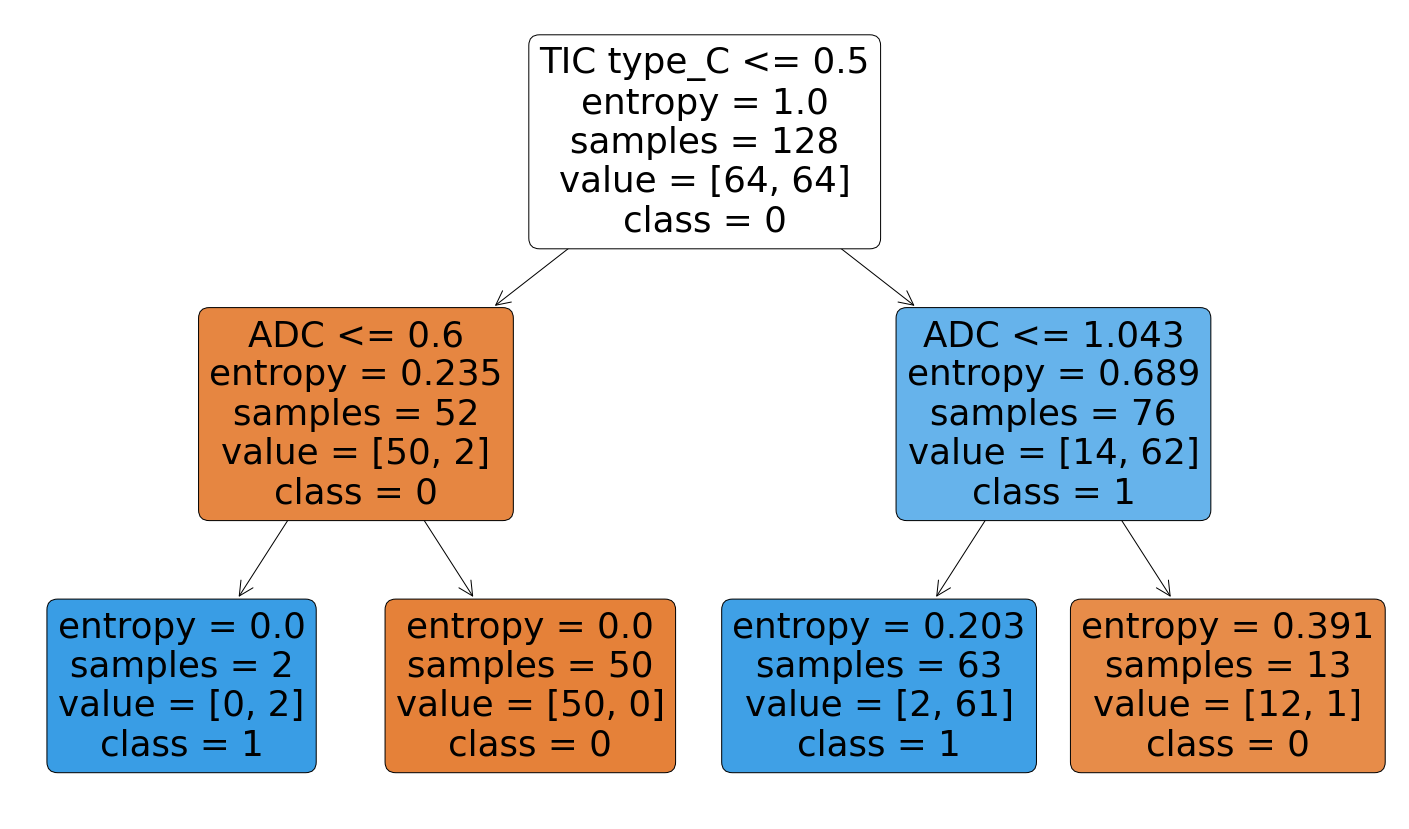

In [5]:
# 1,2 vs 3,4,5

seed = 42

esperimento_estrazionefeature(X, y, random_state_tree = seed, smotenc_aug = True, scoring_f = f1_score,
           print_best_tree = True)

### ITERATION 1 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Labels prepared ##
# Tuning hyper-parameters #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}
Feature importances of estimator:

Segni macro malignità    0.95184
ADC                      0.00000
T2                       0.00000
TIC type_A               0.00000
TIC type_B               0.00000
TIC type_C               0.04816
dtype: float64

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.978

Scores on test set:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        23
           1       1.00      0.67      0.80         3

    accuracy                           0.96        26
   macro avg       0.98      0.83      0.89        26
weighted avg       0.96      0.96      0.96        26

Selected score on test set: 0.958
----

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 4}
Feature importances of estimator:

Segni macro malignità    0.871428
ADC                      0.060322
T2                       0.000000
TIC type_A               0.000000
TIC type_B               0.000000
TIC type_C               0.068250
dtype: float64

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.978

Scores on test set:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93        23
           1       0.50      0.67      0.57         3

    accuracy                           0.88        26
   macro avg       0.73      0.79      0.75        26
weighted avg       0.90      0.88      0.89        26

Selected score on test set: 0.892
----------------------------------------------------------------------------------------------------
### ITERATION 10 ###


## Dataset spl

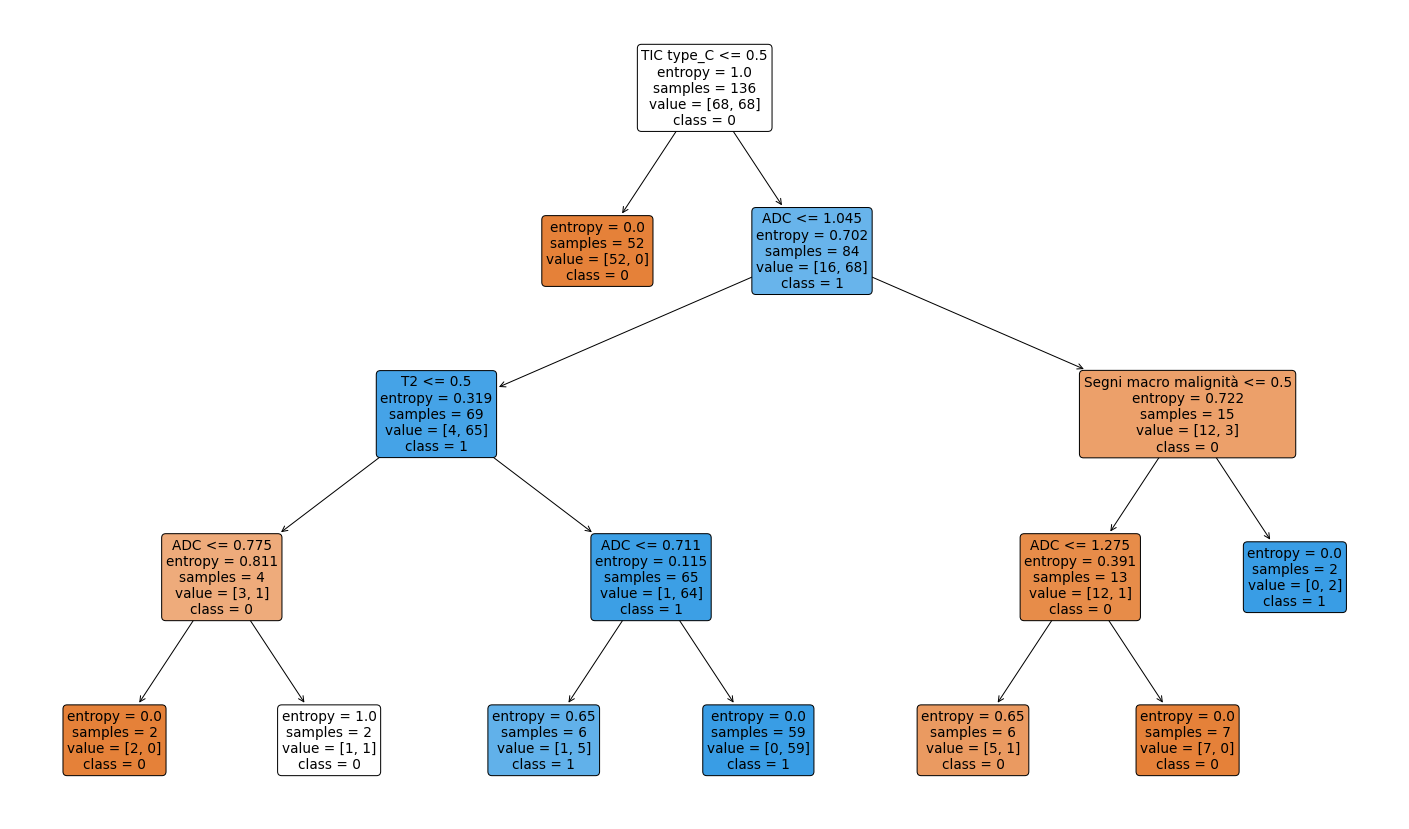

In [6]:
# 1 vs all

seed = 42

esperimento_estrazionefeature(X, y, random_state_tree = seed, smotenc_aug = True, scoring_f = f1_score,
           print_best_tree = True, target_labels = (1,))

### ITERATION 1 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Labels prepared ##
# Tuning hyper-parameters #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}
Feature importances of estimator:

Segni macro malignità    0.0
ADC                      1.0
T2                       0.0
TIC type_A               0.0
TIC type_B               0.0
TIC type_C               0.0
dtype: float64

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 1.000

Scores on test set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00         1

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26

Selected score on test set: 1.000
----------------------------

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}
Feature importances of estimator:

Segni macro malignità    0.0
ADC                      1.0
T2                       0.0
TIC type_A               0.0
TIC type_B               0.0
TIC type_C               0.0
dtype: float64

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 1.000

Scores on test set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00         1

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26

Selected score on test set: 1.000
----------------------------------------------------------------------------------------------------
### ITERATION 10 ###


## Dataset split completed ##
## SMOTENC aug

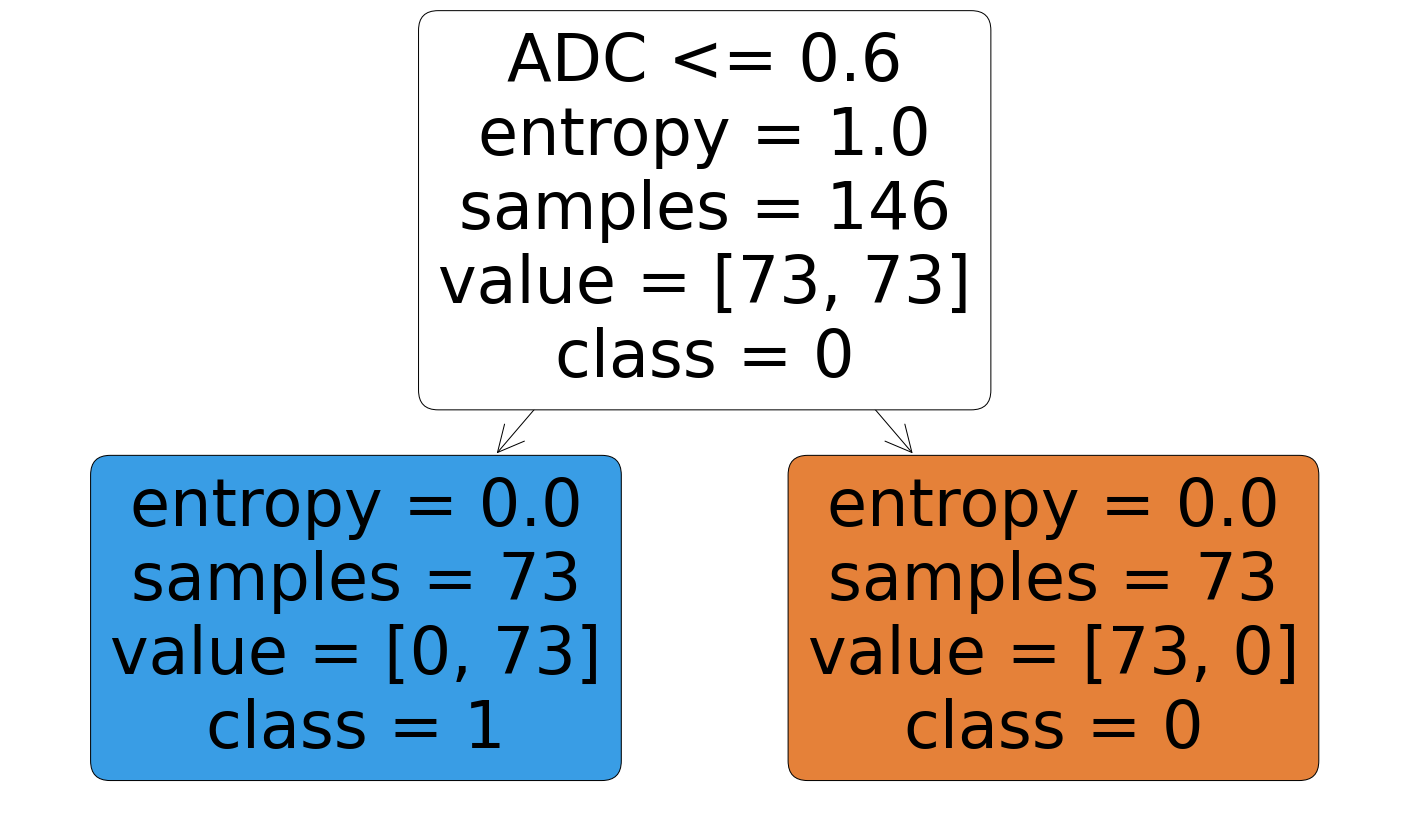

In [7]:
# 2 vs all

seed = 42

esperimento_estrazionefeature(X, y, random_state_tree = seed, smotenc_aug = True, scoring_f = f1_score,
           print_best_tree = True, target_labels = (2,))

### ITERATION 1 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Labels prepared ##
# Tuning hyper-parameters #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}
Feature importances of estimator:

Segni macro malignità    0.000000
ADC                      0.257624
T2                       0.000000
TIC type_A               0.742376
TIC type_B               0.000000
TIC type_C               0.000000
dtype: float64

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.938

Scores on test set:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        13
           1       0.87      1.00      0.93        13

    accuracy                           0.92        26
   macro avg       0.93      0.92      0.92        26
weighted avg       0.93      0.92      0.92        26

Selected score on test set: 0.92

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2}
Feature importances of estimator:

Segni macro malignità    0.000000
ADC                      0.264308
T2                       0.041894
TIC type_A               0.693798
TIC type_B               0.000000
TIC type_C               0.000000
dtype: float64

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.887

Scores on test set:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      0.85      0.92        13

    accuracy                           0.92        26
   macro avg       0.93      0.92      0.92        26
weighted avg       0.93      0.92      0.92        26

Selected score on test set: 0.923
----------------------------------------------------------------------------------------------------
### ITERATION 10 ###


## Dataset spl

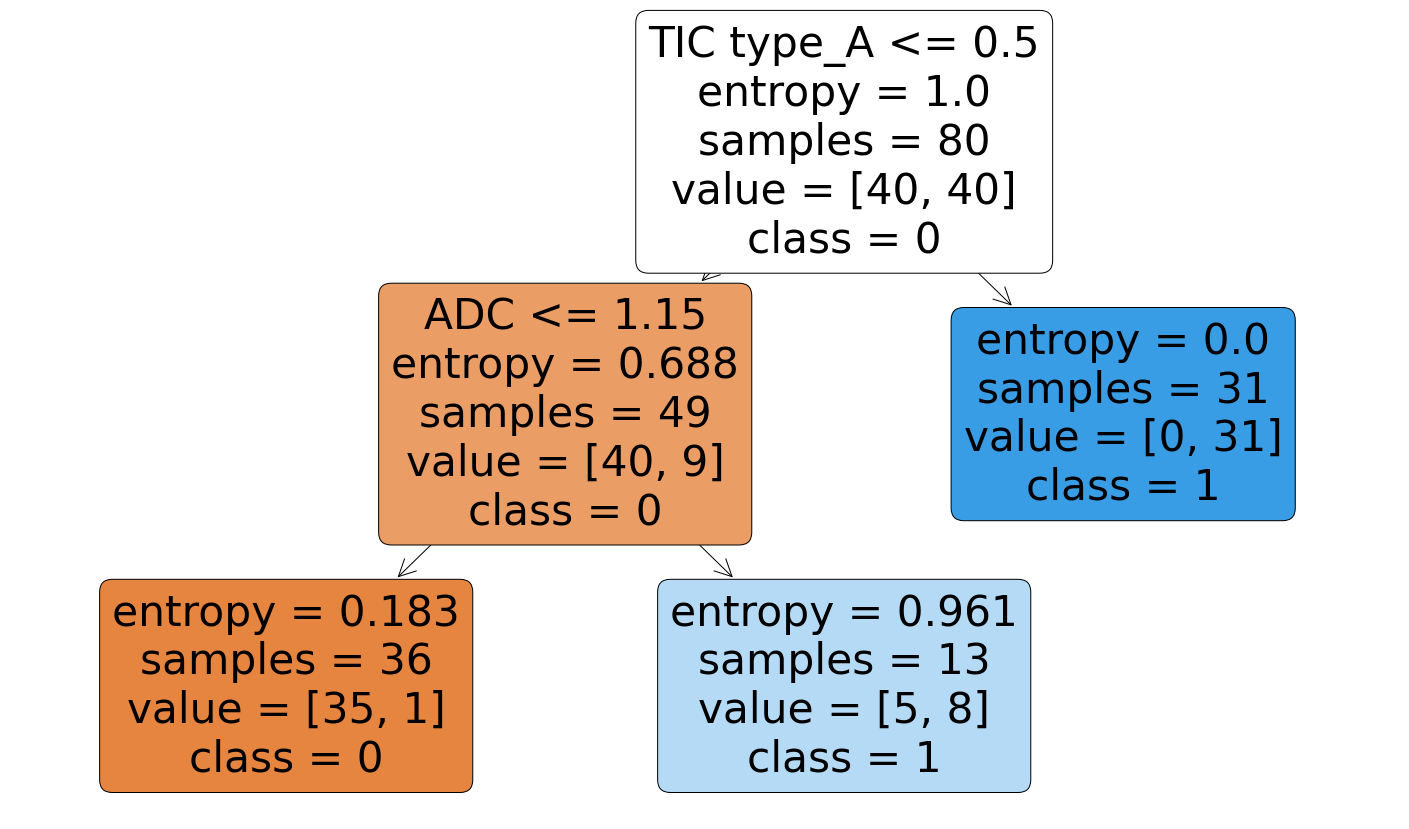

In [8]:
# 3 vs all

seed = 42

esperimento_estrazionefeature(X, y, random_state_tree = seed, smotenc_aug = True, scoring_f = f1_score,
           print_best_tree = True, target_labels = (3,))

### ITERATION 1 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Labels prepared ##
# Tuning hyper-parameters #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}
Feature importances of estimator:

Segni macro malignità    0.000000
ADC                      0.110537
T2                       0.000000
TIC type_A               0.000000
TIC type_B               0.889463
TIC type_C               0.000000
dtype: float64

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.982

Scores on test set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00         7

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26

Selected score on test set: 1.00

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}
Feature importances of estimator:

Segni macro malignità    0.000000
ADC                      0.150735
T2                       0.000000
TIC type_A               0.000000
TIC type_B               0.849265
TIC type_C               0.000000
dtype: float64

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 1.000

Scores on test set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00         7

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26

Selected score on test set: 1.000
----------------------------------------------------------------------------------------------------
### ITERATION 10 ###


## Dataset spl

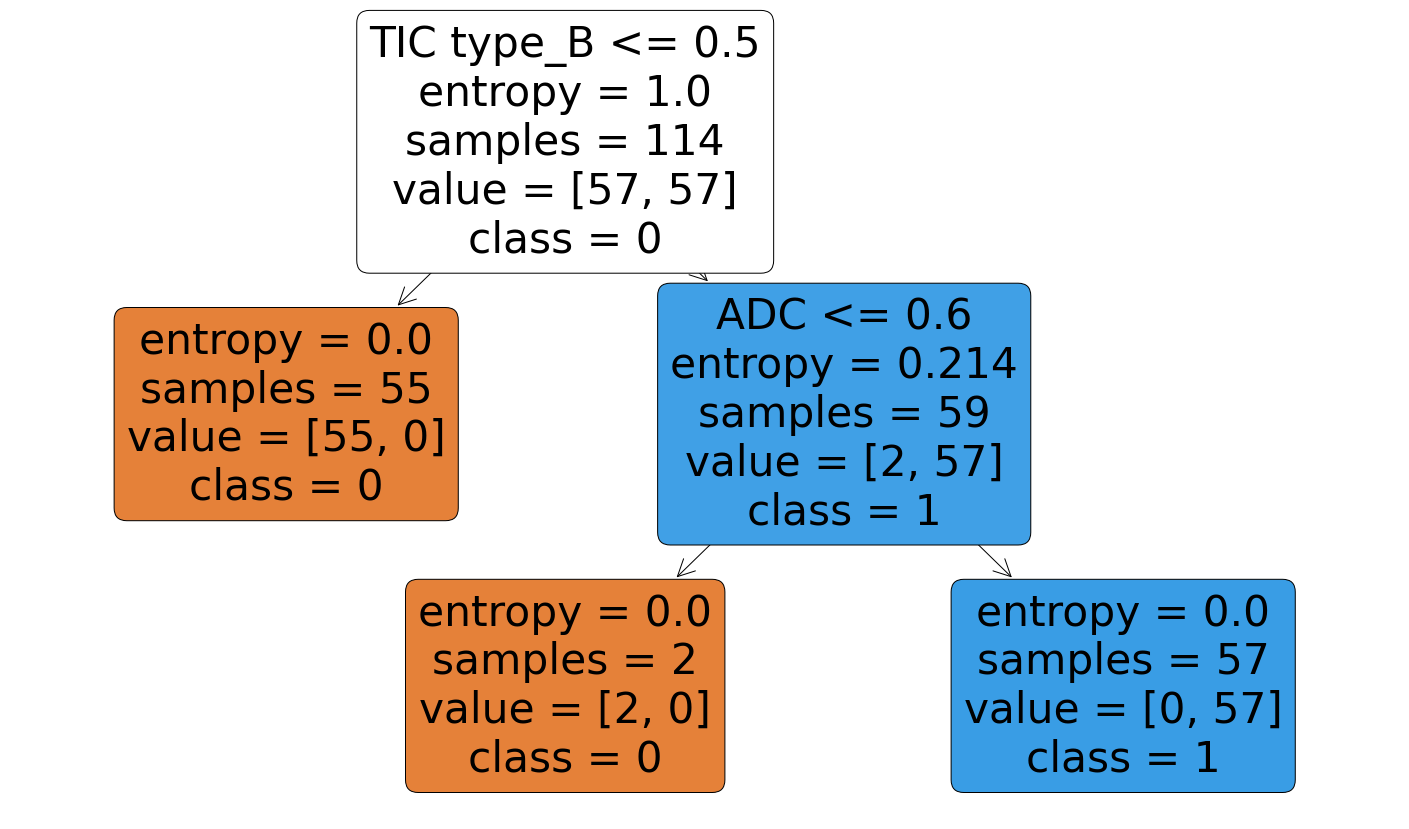

In [9]:
# 4 vs all

seed = 42

esperimento_estrazionefeature(X, y, random_state_tree = seed, smotenc_aug = True, scoring_f = f1_score,
           print_best_tree = True, target_labels = (4,))

### ITERATION 1 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Labels prepared ##
# Tuning hyper-parameters #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2}
Feature importances of estimator:

Segni macro malignità    0.000000
ADC                      0.379521
T2                       0.000000
TIC type_A               0.000000
TIC type_B               0.000000
TIC type_C               0.620479
dtype: float64

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.938

Scores on test set:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        24
           1       0.00      0.00      0.00         2

    accuracy                           0.85        26
   macro avg       0.46      0.46      0.46        26
weighted avg       0.85      0.85      0.85        26

Selected score on test set: 0.84

## SMOTENC augmentation completed ##
## Labels prepared ##
# Tuning hyper-parameters #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 3}
Feature importances of estimator:

Segni macro malignità    0.000000
ADC                      0.271377
T2                       0.101959
TIC type_A               0.000000
TIC type_B               0.000000
TIC type_C               0.626664
dtype: float64

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.959

Scores on test set:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        24
           1       0.00      0.00      0.00         2

    accuracy                           0.85        26
   macro avg       0.46      0.46      0.46        26
weighted avg       0.85      0.85      0.85        26

Selected score on test set: 0.846
--------------------------------------------------

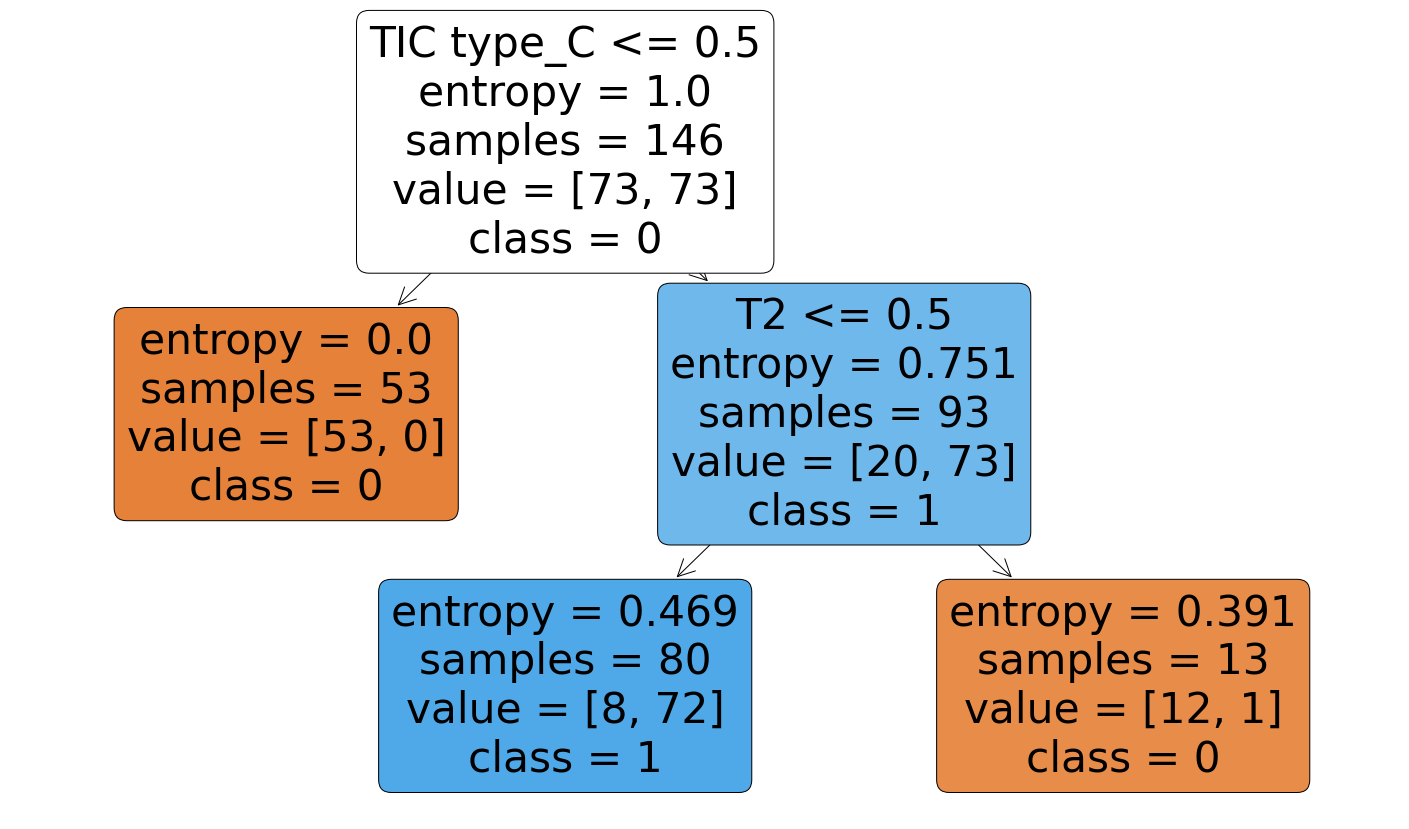

In [10]:
# 5 vs all

seed = 42

esperimento_estrazionefeature(X, y, random_state_tree = seed, smotenc_aug = True, scoring_f = f1_score,
           print_best_tree = True, target_labels = (5,))